# Table of Contents

#### Data Processing
- [Getting the Data](#getting-the-data)
    - [Streaming History](#streaming-history)
    - [Artists in my Library](#artists-in-my-library)
    - [Songs in my Library](#songs-in-my-library)
    
***

#### Data Analysis
- [Summary Statistics](#summary-statistics)
- [High-level Trends](#high-level-trends)
    - [Distribution of Listening by Artist](#distribution-of-listening-by-artist)
    - [Sonic Composition](#sonic-composition)
    - [Temporal Patterns](#temporal-patterns)
- [Statistical Insights](#statistical-insights)
    - [Listening Time and Library Addition](#listening-time-and-library-addition)
    - [Is the Next Song by the Same Artist?](#is-the-next-song-by-the-same-artist)

#### Complete List of All Python Modules Used (in Alphabetical Order)

`better_profanity`, `datetime`, `json`, `lyricsgenius`, `matplotlib`, `numpy`, `pandas`, `pytz`, `re`, `requests`, `scipy`, `seaborn`, `sklearn`, `spotipy`, `statsmodels`, `time`, `timeout_decorator`,
`tqdm`, `warnings`

# Getting the Data <a class="anchor" id="getting-the-data"></a>

In [ ]:
import json
import numpy as np
import pandas as pd
from time import sleep
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from my_utils import *

In [ ]:
sp = get_spotipy_api()
genius = get_lyricsgenius_api()

While most of the data will come from Spotify, I will be gathering that data in a variety of ways. On its own, each avenue is somewhat limited - Spotify makes things more difficult than they need to be.
1. Data that I requested from Spotify via [this method](https://support.spotify.com/us/article/data-rights-and-privacy-settings/), which was emailed to me in a zipped format. From this, I will be using my streaming history from the past year.
2. Data pulled from Spotify's [Spotipy](https://spotipy.readthedocs.io/en/master/) Python library for their web API. I use this to get audio features for tracks once I have their identifiers (URIs).
3. Data pulled directly via the [Spotify API](https://developer.spotify.com/documentation/web-api/) with requests. I use this to get a complete list of all of the songs I've added to my liked songs, including their URIs and when I added them to my library. Note: the zip file from Spotify also contains my library, but does not contain the dates each track was added.
4. Lyrics (for most songs) obtained via the [lyricsgenius](https://lyricsgenius.readthedocs.io/en/master/) Python library for the [Genius API](https://docs.genius.com/).

## Streaming History <a class="anchor" id="streaming-history"></a>

In [ ]:
with open("data/raw/StreamingHistory0.json",) as f: 
    streaming_df = pd.DataFrame(json.load(f))

In [ ]:
streaming_df.head()

#### Processing

Per [Understanding my data](https://support.spotify.com/us/article/understanding-my-data/), 
* `endTime` gives the data and time when the streaming of the track ended, in UTC time zone.
* `artistName` is the artist's name
* `trackName` is the title of the song or podcast
* `msPlayed` gives the number of milliseconds the track was played

Milliseconds aren't incredibly meaningful to us, so let's create a new column `secondsPlayed` which converts this to seconds:

In [ ]:
streaming_df = convert_ms_to_s(streaming_df, 'msPlayed', 'secondsPlayed')

We'll also perform some preliminary operations to take `endTime`, which is a string, and turn it into some meaningful temporal data. We will extract from `endTime` a `datetime` object in UTC, then convert this to pacific time (PT), where I am primarily based.

In [ ]:
streaming_df['dateTime_UTC'] = streaming_df.apply(lambda x: str_to_datetime_no_seconds(x['endTime']), axis =1)
streaming_df['dateTime'] = streaming_df.apply(lambda x: convert_UTC_to_PT(x['dateTime_UTC']), axis = 1)
streaming_df = streaming_df.drop('endTime', axis = 1)

Because they will be useful later, I will also create columns for the `dayOfWeek` $\in \{ Monday, \ldots, Sunday\}$, the `hour`, in PT, and the relative `dayNumber`, with $dayNumber = 0$ for the first day present in streaming DataFrame.

In [ ]:
start_date = get_date_from_datetime_obj(streaming_df['dateTime'][0])
streaming_df['dayNumber'] = streaming_df.apply(lambda x: (x['dateTime'] - start_date).days, axis = 1)
streaming_df['dayOfWeek'] = streaming_df.apply(lambda x: x['dateTime'].strftime('%A'), axis = 1)
streaming_df['hour'] = streaming_df.apply(lambda x: int(x['dateTime'].strftime('%H')), axis = 1)

In [ ]:
streaming_df.head()

Finally, we need to remove all of the podcasts - Spotify combines the streaming history for both songs and podcasts, and without a URI, there isn't a great way to do this. As a work-around, I find every 'artist' that has a track that I listen to for more than $15$ minutes, and discard all tracks from those artists.

In [ ]:
podcast_names = list(streaming_df[streaming_df['secondsPlayed']>15*60]['artistName'].unique())
podcast_names += ['The Daily', 'NFT Music Conference'] ## Need to add a few in manually...

In [ ]:
streaming_df = streaming_df[~streaming_df['artistName'].isin(podcast_names)]

Now we'll save this processed data:

In [ ]:
streaming_file = "data/processed/streaming.csv"
streaming_df.to_csv(streaming_file, index=False)

### to read from file:
streaming_df = pd.read_csv(streaming_file, index_col = None)

## Artists in my Library <a class="anchor" id="artists-in-my-library"></a>

In [ ]:
with open("data/raw/YourLibrary.json",) as f:
    artists_df = pd.DataFrame(json.load(f)['artists'])

In [ ]:
artists_df.head()

#### Processing

Spotify only gives me the artist's name and identifier (URI). I'm going to supplement this data pulled via spotipy. In particular, for each artist I'm going to get:
1. `popularity`: Their popularity score, which goes from $0$ (not popular at all) to $100$ (most popular).
2. `followers`: The total number of people that follow them on Spotify.
3. `genres`: Spotify provides a list of genres (very splintered) for each artist. Because there are so many genres, it doesn't really make sense to create a separate column for each one. Instead, I concatenate these strings and save them as a single string.

In [ ]:
from time import sleep

def supplement_artist_df(artists_df):
    artists_df['popularity'] = np.nan
    artists_df['followers'] = np.nan
    artists_df['genres'] = ''
    
    for i in range(len(artists_df)):
        uri = artists_df['uri'][i]
        response = sp.artist(uri)
        artists_df.at[i, 'popularity'] = response['popularity']
        artists_df.at[i, 'followers'] = response['followers']['total']
        artists_df.at[i, 'genres'] = ' '.join(response['genres'])
        sleep(0.5)
    return artists_df

In [ ]:
artists_df = supplement_artist_df(artists_df)

Now we can save this as well:

In [ ]:
artists_file = "data/processed/artists.csv"
artists_df.to_csv(artists_file, index=False)

### to read from file:
artists_df = pd.read_csv(artists_file, index_col = None)

## Songs in my Library <a class="anchor" id="songs-in-my-library"></a>

As mentioned above, the `library/tracks` data that Spotify gives me is not very helpful. It does not contain the date/time added to my library, nor does it contain any useful audio data about the tracks themselves. I'm going to construct a more meaningful dataset via a three-stage process. The steps are as follows:
1. Query the Spotify web API directly with `requests` to get all of the tracks in my liked songs collection on Spotify. For each track, this gives me `trackName`, `artistName`, `timeAdded` - when I added the track to my library, and `uri`, the unique resource identifier.
2. Add audio features using spotipy library.
3. Add lyrics using lyricsgenius library (for Genius API)

### Note

The code in this section will not work if you try to run it out of the box. This is because you need you need authentication information (i.e. tokens, client_ids, ...) for each of the APIs. My authentication tokens are in `config.py`, which is called by functions in `my_utils.py`, but is not listed in the Github repo (it's in my `.gitignore` file). This section is included purely for transparency and completeness. If you want to run the code, I suggest starting in the Analyses section.

### Get Tracks from Spotify

In [ ]:
def get_spotify_tracks(num_liked_tracks, num_tracks_per_call = 50):
    print(num_liked_tracks)
    print(num_tracks_per_call)
    num_calls = int(np.ceil(num_liked_tracks/num_tracks_per_call))
    print(num_calls)
    limit = num_tracks_per_call
    print(limit)
    trackName, artistName, timeAdded, uri = [], [], [], []
    
    for c in range(num_calls):
        print('c = {}'.format(c))
        offset = c*num_tracks_per_call
        tracks_dict = get_tracks_from_spotify(limit, offset)
        print(tracks_dict)
        for dict_item in tracks_dict['items']:
            timeAdded.append(dict_item['added_at'])
            t = dict_item['track']
            trackName.append(t['name'])
            artistName.append(t['artists'][0]['name'])
            uri.append(t['uri'])    
    
    tracks_df = pd.DataFrame({'artistName': artistName, 'trackName': trackName, 'timeAdded': timeAdded, 'uri': uri})
    tracks_df['timeAdded_UTC'] = tracks_df.apply(lambda x: datetime.datetime.strptime(x['timeAdded'], '%Y-%m-%dT%H:%M:%SZ'), axis = 1)
    tracks_df['timeAdded'] = tracks_df.apply(lambda x: convert_UTC_to_PT(x['timeAdded_UTC']), axis = 1)
    return tracks_df

In [ ]:
num_liked_tracks = 4081
tracks = get_spotify_tracks(num_liked_tracks, num_tracks_per_call)

### Add Audio Features

We will make use of the `spotipy.audio_features()` method to supplement the data Spotify has given us with additional features. Per [Spotify's Web API Reference](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features). For completeness, here are brief descriptions of what each feature captures, and the range of numerical values it can take, paraphrased from the API reference:

* `acousticness`: Confidence measure of whether track is acoustic. **Allowed values**: $\in [0, 1]$. A value of $1.0$ means we are confident the track is acoustic.
* `danceability`: How suitable a track is for dancing. **Allowed values**: $\in [0, 1]$. A value of $1.0$ means the track is very danceable.
* `energy`: How 'intense' or 'active' the track feels. **Allowed values**: $\in [0, 1]$. A value of $1.0$ means the track is very energetic.
* `instrumentalness`: Prediction of whether the track contains no vocals. **Allowed values**: $\in [0, 1]$. A value of $1.0$ means we are confident the track contains no vocals.
* `liveness`: Whether an audience was or was not present. **Allowed values**: $\in [0, 1]$. A value above $0.8$ means we are confident the track was recorded from a live performance.
* `speechiness`: How strongly the track is dominated by spoken words. **Allowed values**: $\in [0, 1]$. A value of $1.0$ means the track is entirely speech-like.
* `valence`: Essentially how happy the track sounds. **Allowed values**: $\in [0, 1]$. A value of $1.0$ means the track is very happy.
* `tempo`: Estimated BPM of track. **Allowed values**: $\in \mathbb{R}$.
* `loudness`: Average loudness in decibals (dB). **Range**: $\in [-60, 0]$.
* `mode`: Modality - major or minor. **Allowed values**: $\in \{0, 1\}$. Major $\rightarrow 1$, and minor $\rightarrow 0$.
* `time_signature`: Meter - number of beats per bar. **Allowed values**: $\in [3, 7]$.
* `key`: Key the track is in, in pitch notation. **Allowed values**: $\in \{-1, \ldots, 11\}$, with $-1$ associated with no key being found.

In [ ]:
def add_audio_features(tracks_df):
    new_keys = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                     'duration_ms', 'time_signature']
    ### Add new columns to the df
    for k in new_keys:
        if k not in tracks_df.columns:
            tracks_df[k] = np.nan

    nrows = len(tracks_df)
    rows_per_call = 100 ### spotipy function limit
    ncalls = int(np.ceil(nrows/rows_per_call))
    
    for i in range(ncalls):
        lb, ub = i * rows_per_call, min((i+1)* rows_per_call, nrows+1)-1
        tids = list(tracks_df.loc[lb:ub]['uri'])
        response = sp.audio_features(tracks = tids)
        inds = np.arange(lb, ub)
        
        for k in new_keys:
            vals = [response[i][k] for i in range(len(inds))]
            tracks_df.loc[inds , k] = vals
    tracks_df = convert_ms_to_s(tracks_df)
    tracks_df = tracks_df.dropna()
    return tracks_df

In [ ]:
tracks_df = add_audio_features(tracks_df)

In [ ]:
tracks_df.head()

Now let's save this:

In [ ]:
tracks_file = "data/processed/tracks.csv"
tracks_df.to_csv(tracks_file, index=False)

### to read from file:
tracks_df = pd.read_csv(tracks_file, index_col = None)

### Get Lyrics

Now I'm going to use the Genius API (via the [LyricsGenius](https://lyricsgenius.readthedocs.io/en/master/) Python library) to get lyrics for as many of these songs as I can. I am using optional start_ind index and num_steps because when I tried to send too many requests in a short timeframe it froze or crashed.

In [ ]:
from better_profanity import profanity #### to remove offensive language
def add_lyrics_to_songs(tracks_df, start_ind = 0, num_steps = None):
    num_steps = len(liked_tracks_df) if num_steps is None else num_steps
    num_tracks = len(tracks_df)
    
    song = None
    tracks_with_lyrics_file = "data/processed/tracks_with_lyrics.csv"
    
    if 'lyrics' not in tracks_df.columns:
        tracks_df['lyrics'] = ''
        
    for i in tqdm(range(num_steps)):
        if i + start_ind > len(tracks_df):
            break
        tracks_df.to_csv(tracks_with_lyrics_file, index=False)
        track = tracks_df.loc[i+start_ind]
        trackName = re.sub("\(+feat.*?\)+", "", track['trackName']).strip()
        artistName = track['artistName']
        
        try:
            song = get_genius_song(trackName, artistName)
        except:
            pass
        
        if song is not None:
            tracks_df.at[i+start_ind, 'lyrics'] = profanity.censor(format_lyrics(song.lyrics))
        
    return tracks_df

In [ ]:
tracks_df = add_lyrics_to_songs(tracks_df)

In [ ]:
tracks_df.head()

In [ ]:
tracks_with_lyrics_file = "data/processed/tracks_with_lyrics.csv"
tracks_df.to_csv(tracks_with_lyrics_file, index=False)

# ### to read from file:
tracks_df = pd.read_csv(tracks_with_lyrics_file, index_col = None)

#
***

# Data Analysis <a class="anchor" id="analyses"></a>

### Loading in data

In [1]:
import json
import numpy as np
import pandas as pd
from time import sleep
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from my_utils import *

In [2]:
markers = ['d', '*', 's', '+', '^', 'x', 'o']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'brown']

Load in gathered and processed data:

In [3]:
streaming_file = "data/processed/streaming.csv"
artists_file = "data/processed/artists.csv"
tracks_file = "data/processed/tracks_with_lyrics.csv"

In [4]:
streaming_df = pd.read_csv(streaming_file, index_col = None)
artists_df = pd.read_csv(artists_file, index_col = None)
tracks_df = pd.read_csv(tracks_file, index_col = None)

When the dataframes are stores, datetime objects are converted to strings. We need to convert back:

In [5]:
streaming_df = convert_to_datetime(streaming_df, 'dateTime')
tracks_df = convert_to_datetime(tracks_df, 'timeAdded')

# Summary Statististics <a class="anchor" id="summary-statistics"></a>

## Streaming History

### Number of songs I listened

In [6]:
num_tracks_streamed = len(streaming_df)
num_days = streaming_df.iloc[-1]['dayNumber'] + 1
print("Over the last year I've listened to {} songs.".format(num_tracks_streamed))
print("This comes out to {} tracks per day.".format(np.round(num_tracks_streamed/num_days, 2)))

Over the last year I've listened to 8367 songs.
This comes out to 22.8 tracks per day.


In [7]:
num_unique_tracks_streamed = len(streaming_df.groupby(by = ['artistName', 'trackName'])['trackName'].unique())
print("I listened to {} unique tracks over this time period.".format(num_unique_tracks_streamed))

I listened to 4436 unique tracks over this time period.


**Note**: I group by artist and track because some song names are used by multiple artists. Thus, if just counted the number of unique track names, we would undercount.

### Number of artists I listened to

In [8]:
num_unique_artists_streamed = len(streaming_df['artistName'].unique())
print("I listened to {} unique artists over this time period.".format(num_unique_artists_streamed))

I listened to 2213 unique artists over this time period.


### Listening time

In [9]:
tot_seconds_streamed = streaming_df['secondsPlayed'].sum()
tot_minutes_streamed = tot_seconds_streamed/60
tot_hours_streamed = tot_minutes_streamed/60
print("I streamed {} hours of music on Spotify, for an average of {} minutes per day.".format(np.round(tot_hours_streamed, 2), np.round(tot_minutes_streamed/num_days, 2)))

I streamed 306.99 hours of music on Spotify, for an average of 50.19 minutes per day.


In [10]:
tracks_by_time_played = streaming_df[['artistName', 'trackName', 'secondsPlayed']].groupby(by = ['artistName', 'trackName']).sum('secondsPlayed').sort_values(by = 'secondsPlayed', ascending = False)

##### Songs I listened to the most:

In [11]:
tracks_by_time_played.head()

,,secondsPlayed
artistName,trackName,
Remi Wolf,Photo ID,9179.320
Mac Miller,Woods,7805.273
Remi Wolf,Down The Line,6086.138
((( O ))),Omw,5764.857
Doja Cat,Woman,5071.891


#### Artists I listened to the most times:

In [12]:
num_plays_by_artist = streaming_df['artistName'].value_counts()
num_plays_by_artist.head()

Remi Wolf     288
FKJ           203
Doja Cat      140
Masego        136
Mac Miller    136
Name: artistName, dtype: int64

#### Artists I listened to only once:

In [13]:
artists_played_once = list(num_plays_by_artist[num_plays_by_artist == 1].keys())
print("I listened to {} artists ONLY ONCE.".format(len(artists_played_once)))

I listened to 1103 artists ONLY ONCE.


### Artists in my Library

#### Number of artists I follow:

In [14]:
num_lib_artists = len(artists_df)
print("There are {} artists in my library.".format(num_lib_artists))

There are 50 artists in my library.


Are there any artists I follow that I didn't listen to this year?

In [15]:
artists_in_lib = set(list(artists_df['name']))
artists_listened_to = set(list(streaming_df['artistName'].unique()))
artists_listened_and_in_lib = artists_in_lib.intersection(artists_listened_to)
num_lib_artists_listened_to = len(list(artists_listened_and_in_lib))
print("I listened to {}/{} of the artists I follow.".format(num_lib_artists_listened_to, num_lib_artists))

I listened to 49/50 of the artists I follow.


In [16]:
artists_not_listened_in_lib = artists_in_lib.difference(artists_listened_and_in_lib)
print("The only artists that I follow that I didn't listen to were: {}".format(list(artists_not_listened_in_lib)[0]))
print()

The only artists that I follow that I didn't listen to were: Bee Gees



### What percent of my listening was artists I follow?

In [17]:
percent_artists_in_lib = 100*num_lib_artists_listened_to/num_unique_artists_streamed
print("Artists in my library made up {}% of the artists I listened to.".format(np.round(percent_artists_in_lib, 2)))

Artists in my library made up 2.21% of the artists I listened to.


In [18]:
num_streams_from_lib_artists = len(streaming_df[streaming_df['artistName'].isin(list(artists_in_lib))])
percent_streams_from_lib_artists = 100*num_streams_from_lib_artists/num_tracks_streamed
print("These artists accounted for {}% of my songs streamed!".format(np.round(percent_streams_from_lib_artists, 2)))

These artists accounted for 21.93% of my songs streamed!


In [19]:
lib_artists_seconds_streamed = streaming_df[streaming_df['artistName'].isin(list(artists_in_lib))]['secondsPlayed'].sum()
percent_time_from_lib_artists = 100 * lib_artists_seconds_streamed/tot_seconds_streamed
print("These artists accounted for {}% of my total listening time!".format(np.round(percent_time_from_lib_artists, 2)))

These artists accounted for 24.09% of my total listening time!


### Popularity of artists I follow

In [20]:
artists_df[['popularity','followers']].agg(['min', 'median', 'mean','max'])

,popularity,followers
min,0.0,121.00
median,66.0,791256.00
mean,64.3,6491994.26
max,95.0,68569580.00


## Songs in my Library

In [21]:
num_liked_songs = len(tracks_df)
print("I have {} songs in my library.".format(num_liked_songs))

I have 4081 songs in my library.


### Number of songs added by year

In [22]:
counts_by_year = tracks_df.groupby([tracks_df.timeAdded.dt.year])
counts_by_year = dict(counts_by_year['timeAdded'].count())
print("Year | # songs liked")
print("-"*15)

for k in list(counts_by_year.keys()):
    print("{} | {}".format(k, counts_by_year[k]))

Year | # songs liked
---------------
2015 | 5
2016 | 342
2017 | 353
2018 | 583
2019 | 428
2020 | 782
2021 | 763
2022 | 825


### How many songs have I added since the streaming history began?

In [23]:
tracks_liked_this_year = tracks_df[tracks_df['timeAdded']>streaming_df['dateTime'].min()]
num_tracks_liked_this_year = len(tracks_liked_this_year)
print("I added {} songs during the {} day long period, or roughly {} songs per day.".format(num_tracks_liked_this_year, num_days, np.round(num_tracks_liked_this_year/num_days, 2)))

I added 999 songs during the 367 day long period, or roughly 2.72 songs per day.


### What percent of my streams are from songs in my library?

In [24]:
tracks_df_track_and_artist = tracks_df.apply(lambda x: (x['trackName'], x['artistName']), axis = 1)
streaming_df_track_and_artist = streaming_df.apply(lambda x: (x['trackName'], x['artistName']), axis = 1)

In [25]:
num_streams_from_lib = streaming_df_track_and_artist.isin(list(tracks_df_track_and_artist)).sum()
percent_streams_from_lib = 100 * num_streams_from_lib/num_tracks_streamed
print("{}/{} streams came from songs currently in my library, or {}%".format(num_streams_from_lib, num_tracks_streamed, np.round(percent_streams_from_lib, 2)))

4933/8367 streams came from songs currently in my library, or 58.96%


# High-level Trends <a class="anchor" id="high-level-trends"></a>

## Distribution of Listening by Artist <a class="anchor" id="distribution-of-listening-by-artist"></a>

We saw above that there were a few artists I listened to a lot of times, and a lot of artists I listened to only once. It is worth asking more generally what trend does this follow. What does the distribution of streams look like?

First we get the number of plays by artist:

In [26]:
num_streams_by_artist = streaming_df['artistName'].value_counts().to_numpy()

We can plot this as a histogram

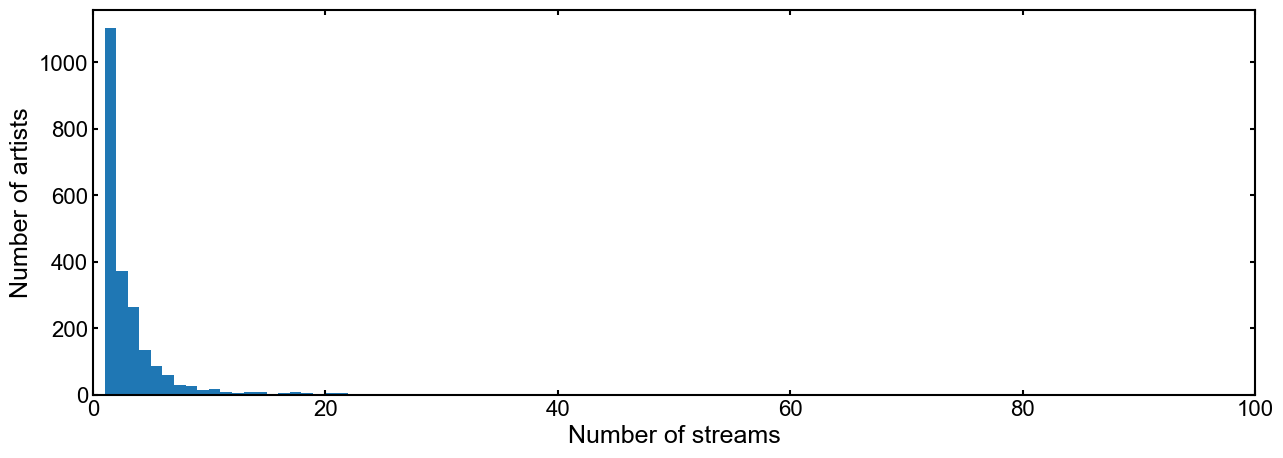

In [27]:
max_plays = num_plays_by_artist.max()
cutoff = 100 ### max 
num_bins = max_plays

fig, ax = plt.subplots(figsize = (15, 5))
ax.hist(num_plays_by_artist, bins = num_bins)

ax.set_xlabel(r'Number of streams')
ax.set_ylabel(r'Number of artists')
ax.set_xlim(0, cutoff)
plt.show()

Here I've cut off the graph at $x = 100$ so we can see the trend, but there are a few artists with more streams than this.

**Observation**: This looks like it might be a good fit to a power law distribution. Let's try it out

## Fitting to power law distribution

Intuitively, it seems reasonable for the data to be modeled by a power law distribution. This family of distributions crops up whenever the winners win big and there is a long tail. This describes a lot of viral trends, including the distribution of streams among musicians. It also describes the frequencies of word occurrences in many languages.

We want to see if the data fits the form $y = k x^{\alpha}$, for some $k, \alpha$. We will do this by linearly fitting $\log(y) = k + \alpha \log(x)$.

We will cut off our analysis at $20$ plays, because below that the data is just a bunch of somewhat random ones and zeros.

In [28]:
cutoff = 20
hist, bins = np.histogram(num_plays_by_artist, bins = max_plays)

x = np.arange(1, cutoff+1)
y = hist[:cutoff]

logx, logy = np.log(x), np.log(y)

In [29]:
popt_powerlaw, resid_powerlaw = curve_fit(lin_func, logx, logy)
k, alpha = popt_powerlaw[0], popt_powerlaw[-1]
print("k_opt = {}".format(np.round(k, 2)))
print("alpha_opt = {}".format(np.round(alpha, 2)))

k_opt = 7.46
alpha_opt = -2.09


Looks like the best power law fit gives roughly a $y \sim 1/x^2$ relationship. 

Let's transform our model back into its original setting and plot our predictions against the data:

In [30]:
xs = np.linspace(x[0], x[-1], 100)
ly_fit = lin_func(np.log(xs), *popt_powerlaw)
yfit_powerlaw = np.exp(ly_fit)

ly_pred = lin_func(np.log(x), *popt_powerlaw)
y_pred = np.exp(ly_pred)

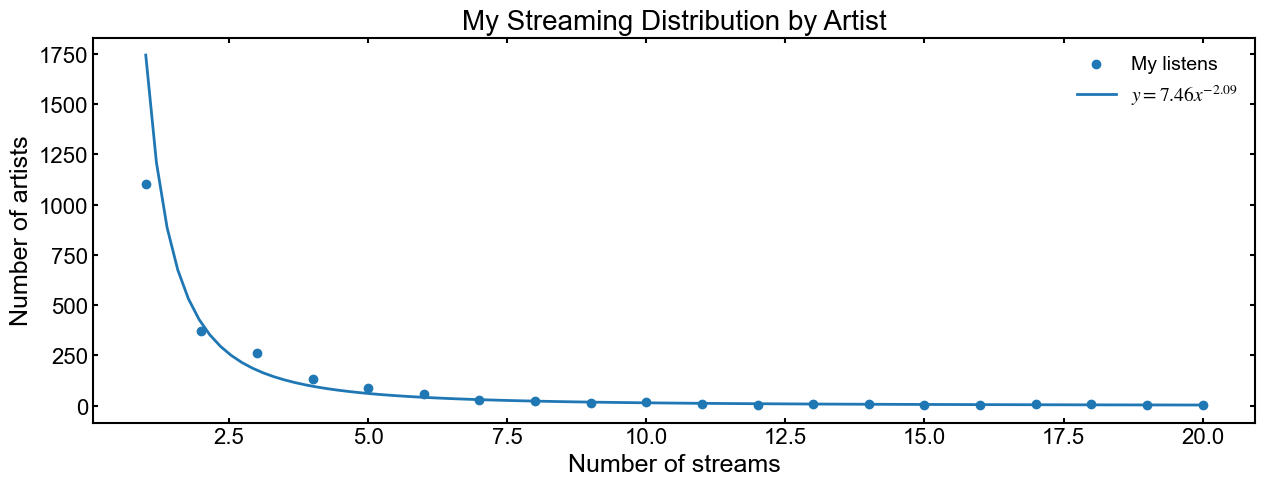

In [31]:
fig, ax = plt.subplots(figsize = (15, 5))

plt.title('My Streaming Distribution by Artist', fontsize = 20)
plt.scatter(x, y, label = r'My listens')
plt.plot(xs, yfit_powerlaw, label = r'$y = %s x^{%s}$'%(np.round(k, 2), np.round(alpha, 2)))
plt.legend(frameon = False, fontsize = 14)
plt.xlabel(r'Number of streams')
plt.ylabel(r'Number of artists')
plt.show()

### Goodness of Fit

Visually the fit between the power law distribution and the actual data looks pretty good, but we can more precisely calculate how good the agreement is using an $R^2$ score:

In [32]:
rsquared = r2_score(logy, ly_pred)
print("R^2 = {}".format(np.round(rsquared, 3)))

R^2 = 0.956


This confirms what we see in the plot above - the fit is fairly good: $R^2 = 1$ would imply a perfect fit.

## Sonic Composition <a class="anchor" id="sonic-composition"></a>

It is also worth asking if there is any sonic or audio-based structure to the music I listen to. There are infinite ways to try to answer this question, but given the data we have, I will use the audio features for each song, extracted from Spotify.

### Features

I'm going to set aside the `mode`, `time_signature`, and `key`, as these are all categorical. We will focus our attention on the continuous-valued audio features: `acousticness`, `danceability`, `energy`, `instrumentalness`, `liveness`, `speechiness`, `valence`, `tempo`, and `loudness`. For the sake of this analysis, we will also ignore the artist, album, and track name, as well as uri.

In [33]:
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo']
audio_features_df = tracks_df[audio_features]

#### Correlation Matrix

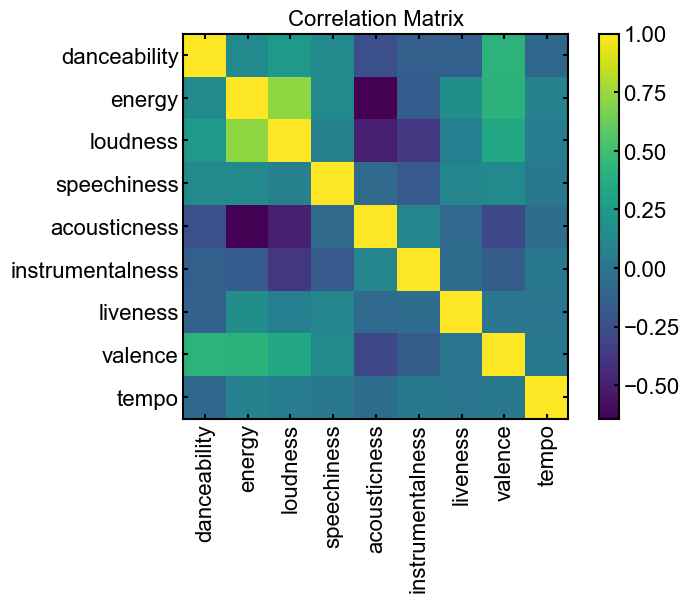

In [34]:
labels = audio_features_df.columns
f = plt.figure(figsize=(8, 5))
plt.imshow(audio_features_df.corr())

ticks = np.arange(0, len(labels))
plt.xticks(ticks, labels = labels, rotation=90)
plt.yticks(ticks, labels = labels)
# plt.set_xticklabels(labels, rotation='vertical')
# plt.set_yticklabels(labels)
cb = plt.colorbar()
plt.title('Correlation Matrix', fontsize=16);
plt.show()

There are two main correlation patterns that we can see in the correlation matrix.
1. Energy and loudness are highly correlated, which makes sense.
2. Energy (and loudness) is inversely correlated with acousticness, which also makes sense.

#### Variance Inflation Factor

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
V = add_constant(audio_features_df)

In [36]:
vifs = pd.Series([variance_inflation_factor(V.values, i) 
               for i in range(V.shape[1])], 
              index=V.columns)
print("Variance Inflation Factors")
print("-"*28)
print(vifs[1:])

Variance Inflation Factors
----------------------------
danceability        1.372556
energy              3.200447
loudness            2.602100
speechiness         1.091183
acousticness        1.783617
instrumentalness    1.261167
liveness            1.074753
valence             1.456588
tempo               1.021332
dtype: float64


A Variance inflation factor (VIF) of between $1$ and $5$ indicates that the variables are only moderately collinear. We should be able to move forward with all of these variables.

In [37]:
X = audio_features_df.to_numpy()

#### Standardization

These variables have very different ranges. To put all of the features on equal footing, we will standardize the data.

In [38]:
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)

### Visualization with t-SNE

Now let's embed this scaled data in a two-dimensional space and visualize the structure

In [39]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(Xscaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4081 samples in 0.004s...
[t-SNE] Computed neighbors for 4081 samples in 0.448s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4081
[t-SNE] Computed conditional probabilities for sample 2000 / 4081
[t-SNE] Computed conditional probabilities for sample 3000 / 4081
[t-SNE] Computed conditional probabilities for sample 4000 / 4081
[t-SNE] Computed conditional probabilities for sample 4081 / 4081
[t-SNE] Mean sigma: 0.663903
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.698479
[t-SNE] KL divergence after 1000 iterations: 1.783544


In [40]:
df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

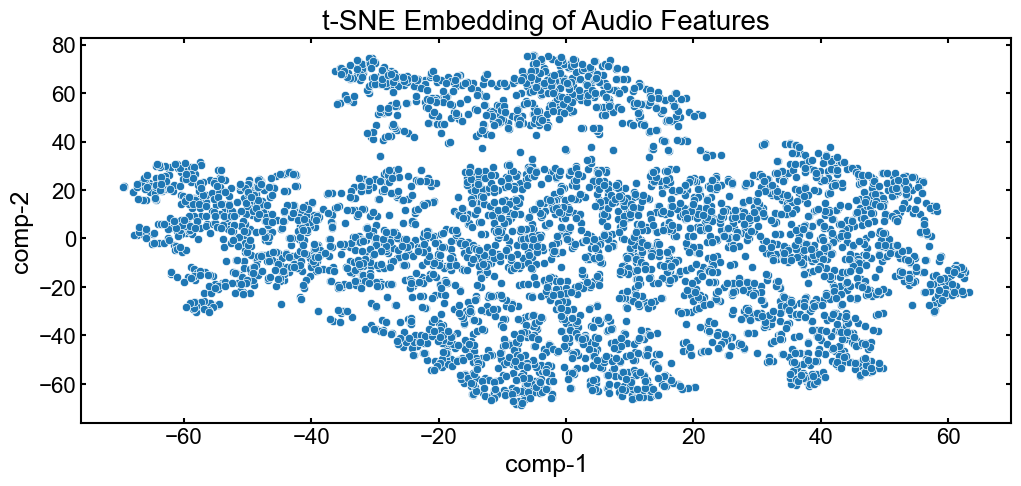

In [41]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.scatterplot(x="comp-1", y="comp-2",
                data=df)
plt.title(r't-SNE Embedding of Audio Features', fontsize = 20)
plt.show()

This is obviously very rough, but it looks like the data splits fairly neatly into two clusters. First, we have the large cluster on bottom. And second, we have a smaller but still present cluster on top. Let's see if clustering on the standardized data recovers the same groupings:

### Gaussian Mixture Clustering

Here we will only be interested in visually investigating the hidden structure in the data. It is reasonable to assume that the data is modeled by a mixture of a "finite number of Gaussians with unknown paramaters". As such, we will cluster the data using a [Gaussian mixture model](https://scikit-learn.org/stable/modules/mixture.html)

In [42]:
from sklearn.mixture import GaussianMixture
n_components = 6 ### Somewhat arbitrarily chosen
model = GaussianMixture(n_components=n_components)
model.fit(z)
yhat = model.predict(z)
df['cluster'] = yhat

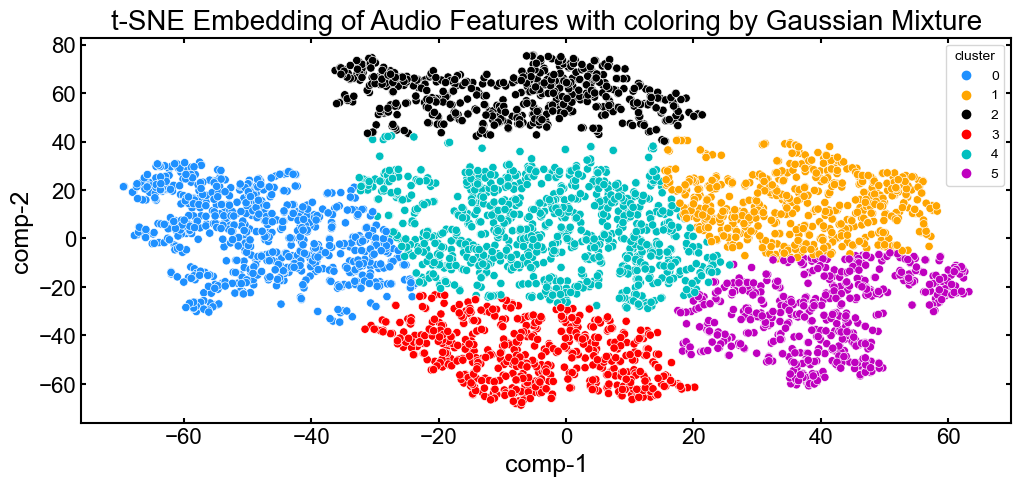

In [43]:
fig, ax = plt.subplots(figsize = (12, 5))
key = 'cluster'
palette=['dodgerblue','orange','black','red', 'c', 'm', 'brown'][:len(list(df[key].unique()))]
sns.scatterplot(x="comp-1", y="comp-2",
                data=df, hue = key, palette = palette)
plt.title(r't-SNE Embedding of Audio Features with coloring by Gaussian Mixture', fontsize = 20)
plt.show()

Looks like the upper cluster is mostly captured by cluster $2$ in the Gaussian Mixture treatment. Let's investigate these tracks:

In [44]:
up_cluster_ind = 2

In [45]:
cluster_inds = {i:df[df['cluster'] == i].index.tolist() for i in range(n_components)}

In [46]:
tracks_df.iloc[cluster_inds[up_cluster_ind]][['trackName', 'artistName']].head(10)

,trackName,artistName
20,Take Me High,Kx5
26,baby shred,Luna Li
34,March,Brian Green
35,Petty,Melanie Charles
39,Actually,Dan Kye
64,White Sand Beach,Xan Griffin
65,Bond - Piano Version,Anomalie
69,Home,LaBlue
71,Mount Harissa,Duke Ellington
73,Caravan,Duke Ellington


Let's see how these tracks differ from the rest of the tracks...

In [47]:
upper_cluster_means = tracks_df.iloc[cluster_inds[up_cluster_ind]][audio_features].mean()
print(upper_cluster_means)

danceability          0.581459
energy                0.469814
loudness            -11.516821
speechiness           0.059915
acousticness          0.440806
instrumentalness      0.691991
liveness              0.151606
valence               0.396789
tempo               115.996212
dtype: float64


In [48]:
lower_cluster_means = tracks_df.loc[~tracks_df.index.isin(cluster_inds[up_cluster_ind])][audio_features].mean()
print(lower_cluster_means)

danceability          0.627112
energy                0.543764
loudness             -8.256760
speechiness           0.117022
acousticness          0.362640
instrumentalness      0.016116
liveness              0.183492
valence               0.473592
tempo               114.090345
dtype: float64


To see how these two clusters differ from each other, let's look at the difference in their average feature values, relative to the size of the average over the entire dataframe:

In [49]:
relative_diffs = (upper_cluster_means-lower_cluster_means)/audio_features_df.mean()
print(relative_diffs)

danceability       -0.073548
energy             -0.138633
loudness            0.374165
speechiness        -0.523766
acousticness        0.209236
instrumentalness    6.106469
liveness           -0.178103
valence            -0.165937
tempo               0.016666
dtype: float64


We can see that `instrumentalness` is by far the most different between the upper and lower cluster! It looks like about $15\%$ of the music I listen to is more instrumental than not, and the rest of the music I listen to is basically not instrumental at all.

## Temporal Patterns <a class="anchor" id="temporal-patterns"></a>

In [50]:
HOURS_PER_DAY = 24

Now let's see if my Spotify listening and adding songs to my library has any temporal structure.

### Listening by Day

We'll start simple and just get the number of streams by day. The indexing is because we need to fill in missing days - there are some days I didn't listen to any tracks on Spotify 🫢

In [51]:
streams_per_day = streaming_df['dayNumber'].value_counts().sort_index()
start_day = streaming_df['dayNumber'].min()
start_date = streaming_df['dateTime'][0]
end_day = streaming_df['dayNumber'].max()
idx = pd.Series(np.arange(0, end_day + 1))
streams_per_day = streams_per_day.reindex(idx, fill_value=0)

Now we can chart/visualize my listening over the course of the entire year. We'll also take a rolling average as well:

In [52]:
window = 3
moving_streams_per_day = streams_per_day.rolling(window).sum()/window

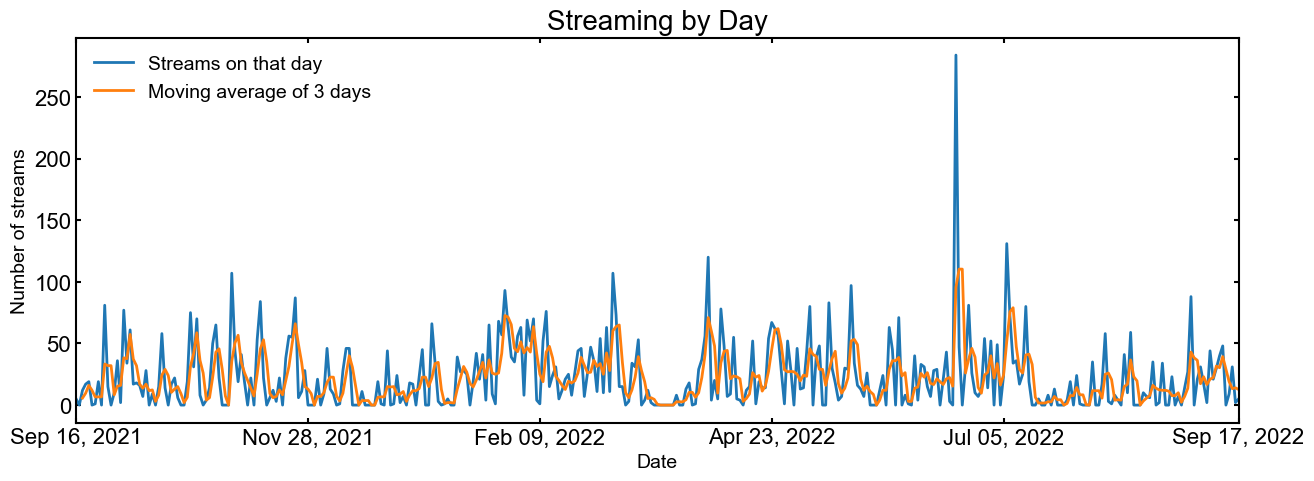

In [53]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(streams_per_day.to_numpy(), label = r'Streams on that day')
ax.plot(moving_streams_per_day.to_numpy(), label = r'Moving average of {} days'.format(window))
ax.legend(frameon = False, fontsize = 14)

ticklabel_dates = [int(d) for d in np.linspace(start_day, end_day, 6, endpoint = True)]
ticklabels = [format_absolute_date(d, start_date) for d in ticklabel_dates]
ax.set_xticks(ticklabel_dates)
ax.set_xticklabels(ticklabels)

ax.set_xlabel(r'Date', fontsize = 14)
ax.set_ylabel(r'Number of streams', fontsize = 14)
plt.xlim(start_day, end_day)
plt.title('Streaming by Day', fontsize = 20)
plt.show()

#### The Peak

This looks interesting. First, let's see what is going on with that big peak:

In [54]:
max_streams = streams_per_day.max()
relative_day = streams_per_day.argmax()
day_of_week = get_absolute_date(relative_day, start_date).strftime('%A')

print('The peak occurs on ' + format_absolute_date(relative_day, start_date) + ', when I listened to {} tracks.'.format(max_streams))
print('The day of week was {}.'.format(day_of_week.upper()))

The peak occurs on Jun 20, 2022, when I listened to 284 tracks.
The day of week was MONDAY.


This sharp peak occurred on my first day of freedom! AKA this was the day that I completed the first rough draft of my Ph.D. thesis and took an 8 hour flight to Oslo with my brother. I think I listened to Spotify almost the entire flight.

### Weekly structure

To extract more structure from this data, let's see if we can break it down on a weekly basis. Reflecting on my music listening habits, there are three periods each week during which I'm more inclined to listen to Spotify:

1. **Discover Weekly**: This comes out on Sunday night at $9$PM PT, and I typically listen to it either on Sunday night or Monday, and occassionally on Tuesday.
2. **New Music Friday**: This comes out on Thursday night at $9$PM PT. More often than not, I listen to it on Thursday night, almost as soon as it comes out, although sometimes I don't get to it until Friday or Saturday.
3. Weekend work: Not a Spotify specific event, but I often go to coffee shops on the weekend and listen to music while working.

Putting all three of these together, I hypothesize that my listening is highest on Thursday and Friday, and lowest on Wednesday. Let's see what the data shows:



In [55]:
streaming_df.value_counts('dayOfWeek')

dayOfWeek
Friday       1522
Thursday     1385
Saturday     1332
Monday       1250
Sunday       1207
Wednesday     952
Tuesday       719
dtype: int64

Finally, let's break this down by time of day:

In [56]:
time_of_day_streams = streaming_df.groupby('dayOfWeek')['hour'].value_counts().sort_index()
days_of_week = list(streaming_df['dayOfWeek'].unique())
hours = np.arange(0, HOURS_PER_DAY)
idx_hours = pd.Series(hours)
xticks = hours[::3]
ticklabel_hours = [format_timeofday(h) for h in xticks]

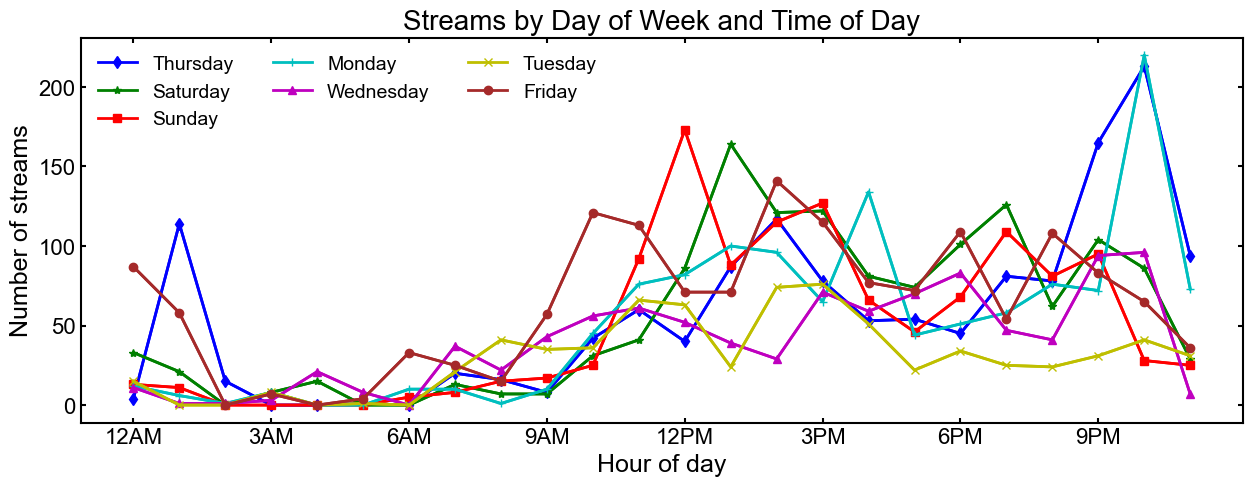

In [57]:
fig, ax = plt.subplots(figsize = (15, 5))
for i, day in enumerate(days_of_week):
    streams_by_hour = time_of_day_streams[day].reindex(idx_hours, fill_value=0).to_numpy()
    ax.plot(hours, streams_by_hour, label = day, marker = markers[i], c = colors[i])
    ax.plot(hours, streams_by_hour, c = colors[i])
ax.set_xticks(xticks)
ax.set_xticklabels(ticklabel_hours)
ax.set_xlabel('Hour of day')
ax.set_ylabel('Number of streams')
ax.legend(frameon = False, ncol = 3, fontsize = 14)
plt.title('Streams by Day of Week and Time of Day', fontsize = 20)
plt.show()

##### Observations

1. The highest peaks occur around $9$PM on Monday and Thursday. These are due to Discover Weekly and New Music Friday. 
2. The second peaks occur midday on Saturday and Sunday - prime coffee shop working hours.

### Audio Features by Month

Unfortunately because Spotify doesn't give the URIs for streaming history, I can't look at how the audio features of my streaming preferences have changed over time. However, I *can* look at how the audio features of the songs I've added to my library have changed over time.

I have a long enough history to work with that we can go back three years. The number of tracks added per day is too low for plots on that scale to be meaningful. To get something more meaningful, we will look at monthly averages for various audio features.

First let's take all tracks data from the last three years and group by month:

In [58]:
tracks_by_month = tracks_df[tracks_df['timeAdded'] > datetime.datetime(2018, 9, 1)]
tracks_by_month = tracks_by_month.groupby([(tracks_by_month.timeAdded.dt.year), (tracks_by_month.timeAdded.dt.month)])

Now let's select only the relevant keys - the continuous-valued audio features:

In [59]:
keys = ['energy', 'danceability', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
tracks_by_month = tracks_by_month[keys]

Now let's get the means of these features by month:

In [60]:
means_by_month = dict(tracks_by_month.mean())
months = means_by_month[keys[0]].keys()

We'll also get the means of these features averaged over all liked tracks:

In [61]:
means_all_time = list(tracks_df[keys].mean())

Finally we will plot the percent deviation by month from overall mean for each of these audio features. This will allow us to see how much each feature has varied in my preferences over time:

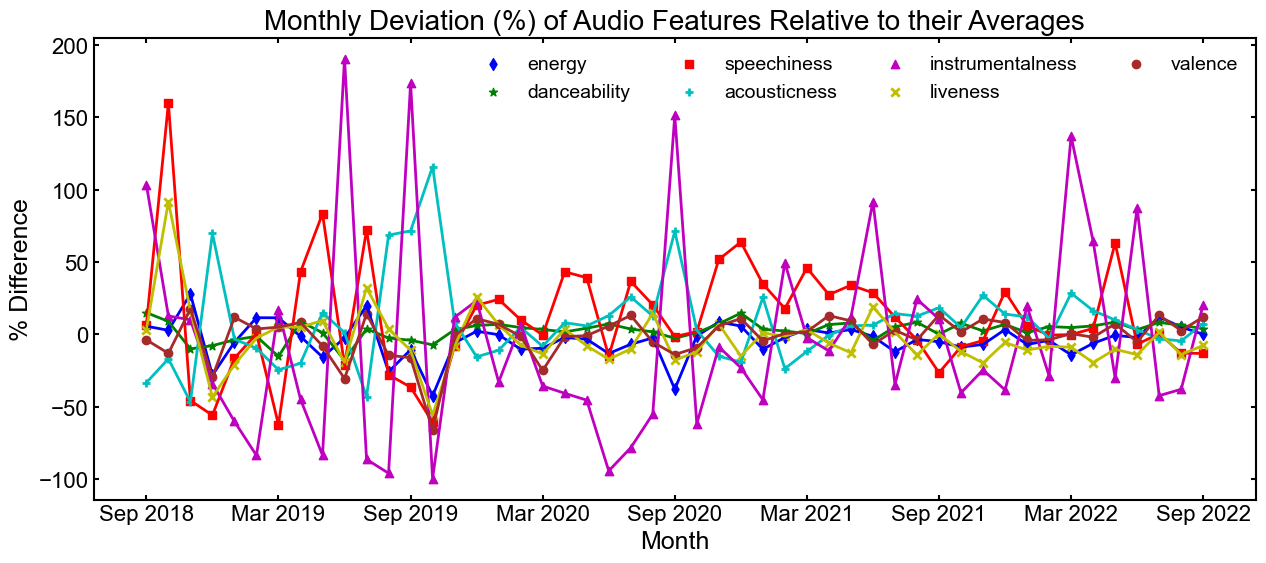

In [62]:
x = np.arange(len(list(months)))
xticks = x[::6]
xtick_months = [list(months)[i] for i in xticks]
ticklabel_months = [format_month(m) for m in xtick_months]

fig, ax = plt.subplots(figsize = (15, 6))

for ik, k in enumerate(keys):
    vals = means_by_month[k].values
    percent_diffs = (vals - means_all_time[ik])/means_all_time[ik] * 100
    ax.plot(x, percent_diffs, c = colors[ik])
    ax.scatter(x, percent_diffs, label = k, c = colors[ik], marker = markers[ik])
    
ax.set_xticks(xticks)
ax.set_xticklabels(ticklabel_months)
ax.set_xlabel('Month')
ax.set_ylabel('% Difference')
ax.set_title('Monthly Deviation (%) of Audio Features Relative to their Averages', fontsize = 20)
ax.legend(frameon = False, ncol = 4, fontsize = 14)
plt.show()    

#### Observations

Looks like valence, danceability, and energy are fairly consistent. Liveness has a spike early on, but aside from that is pretty consistent. There were some acoustic spikes back in the day, but I haven't had a big acoustic phase in two years. The features which change the most are instrumentalness and speechiness, which are naturally anticorrelated. 

It looks like roughly once or twice every year I go through an instrumental phase! This is mostly Jazz...

I thought there would be more variability than this, but after looking at [this](https://www.therecordindustry.io/analyzing-spotify-audio-features/), I think that a lot of music on Spotify isn't diverse along these axes. 

# Statistical Insights <a class="anchor" id="statistical-insights"></a>

## Listening Time and Library Addition <a class="anchor" id="listening-time-and-library-addition"></a>

### Discussion

How long I listen to a song before deciding whether or not to add it to my library?

To address this question, I will use both `tracks_df` and `streaming_df`. I will divide the tracks I listened to into four groups.

* **A**: Songs that were already in my library prior to September $16$th 2021 (when the streaming history starts)
* **B**: Songs that I listened to and did not add to my library
* **C**: Songs that I listened to and added immediately, and
* **D**: Songs that I listened to and added only later

More precisely, to separate groups **C** and **D**, I will use a cutoff of $10$ minutes to determine 'immediate' versus 'later'. Why $10$ minutes? The exact number is arbitrary. The important points are that the gap between listening and adding must be short, but not too short that the results are skewed because I like to finish writing a block of code or need to finish driving somewhere before going into the Spotify app and adding the song to my library.

I will go through my streaming history and find the first time I listened to the song, and then check whether or not I added the song within this $10$ minute window and assign the song to its appropriate group. 

For group **A**, there isn't much we can do here, but for groups **B** - **D**, we can compare the average duration of the first listen. In other words, if I listen to a new song for $s$ seconds before switching to the next song, what are the odds that I add the song to my library? Will I add it immediately, or later on?

### Processing

In [63]:
def split_at_date(tracks_df, date):
    before_tracks_df = tracks_df[tracks_df['timeAdded']<date]
    after_tracks_df = tracks_df[tracks_df['timeAdded']>date]
    return before_tracks_df, after_tracks_df

In [64]:
def generate_artist_track_conditions(dfs, track):
    '''Conditions that will allow us to determine how to handle the given track'''
    new_tracks_df, streaming_df, before_df, after_df = dfs
    (artistName, trackName) = track
    
    streaming_artist_cond = streaming_df["artistName"] == artistName
    streaming_track_cond = streaming_df["trackName"] == trackName
    streaming_cond = streaming_artist_cond & streaming_track_cond
    
    new_tracks_artist_cond = new_tracks_df["artistName"] == artistName
    new_tracks_track_cond = new_tracks_df["trackName"] == trackName
    new_tracks_cond = new_tracks_artist_cond & new_tracks_track_cond
    
    before_artist_cond = before_df["artistName"] == artistName
    before_track_cond = before_df["trackName"] == trackName
    before_cond = before_artist_cond & before_track_cond
    
    after_artist_cond = after_df["artistName"] == artistName
    after_track_cond = after_df["trackName"] == trackName
    after_cond = after_artist_cond & after_track_cond
    
    conds = {'streaming': streaming_cond, 'new': new_tracks_cond, 'before': before_cond, 'after': after_cond}
    return conds

In [65]:
def generate_new_tracks_df(tracks_df, streaming_df):
    
    before_df, after_df = split_at_date(tracks_df, streaming_df['dateTime'].min())
    
    ### Generate new dataframe to fill in:
    column_names = ["trackName", "artistName", "addedQ", "firstPlayTime", "firstPlayDuration", "numPlays"]
    new_tracks_df = pd.DataFrame(columns = column_names)
    
    nstreams = len(streaming_df)
    for i in range(nstreams):
        s = streaming_df.loc[i]
        artistName, trackName = s['artistName'], s['trackName']
        track = (artistName, trackName)
        dfs = [new_tracks_df, streaming_df, before_df, after_df]
        conds = generate_artist_track_conditions(dfs, track)
        
        if len(new_tracks_df[conds['new']]) > 0 or len(before_df[conds['before']]) > 0:
            continue
            
        firstPlayTime, firstPlayDuration = s['dateTime'], s['secondsPlayed']
        numPlays = len(streaming_df[conds['streaming']])
        
         ### If track was added
        if len(after_df[conds['after']]) > 0:
            diff = abs(firstPlayTime - list(after_df[conds['after']]['timeAdded'])[0])
            addedQ = "addedImmediately" if diff < timedelta(minutes = 10) else "addedLater"
        else:
            addedQ = "notAdded"
        
        new_track_dict = {"trackName": trackName, "artistName": artistName, "addedQ": addedQ, "firstPlayTime": firstPlayTime, 
                          "firstPlayDuration": firstPlayDuration, "numPlays": numPlays}
        new_tracks_df = new_tracks_df.append(new_track_dict, ignore_index=True)
            
    return new_tracks_df

In [66]:
new_tracks_df = generate_new_tracks_df(tracks_df, streaming_df)

### Results

In [67]:
new_tracks_df.value_counts('addedQ')

addedQ
notAdded            2811
addedImmediately     802
addedLater           159
dtype: int64

**Note**: The difference in absolute number between `num_tracks_liked_this_year` in the summary statistics $(=999)$ and `addedImmediately` $+$ `addedLater` probably comes from the fact that I'm just matching on artist and track name, not URI identifier. There are probably some that get double dipped into because of multiple versions/renditions. This is not terribly important for the analysis at hand.

Let's get some summary statistics for groups **B** - **D**:

In [68]:
new_tracks_df.groupby('addedQ')['firstPlayDuration'].agg(['mean', 'max', 'median'])

,mean,max,median
addedQ,,,
addedImmediately,171.555369,721.871,184.2115
addedLater,147.752472,426.364,164.4880
notAdded,108.260020,840.933,99.3180


While there appears to be at least one song that I listened to for a long time my first time I played it, and I didn't add it to my library, the mean and median show a clear relationship: Songs that I listen to longer on my first pass through are more likely to be added to my library, and the longer I listen on the first play, the more likely I am to add the song immediately. 

Let's plot this relationship out - what percent of songs in each category did I listen to for $s$ seconds on my first play? 

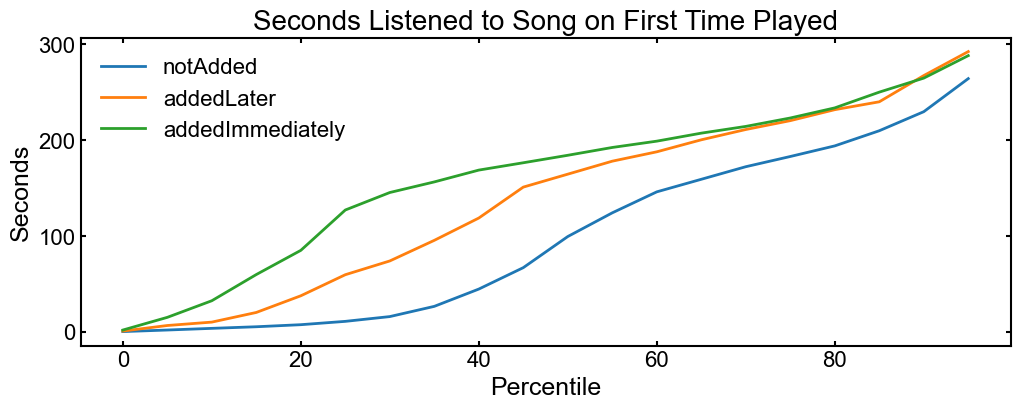

In [69]:
quantile_percents = np.linspace(0, 0.95, 20)
quantiles = new_tracks_df.groupby('addedQ')['firstPlayDuration'].quantile(quantile_percents)

fig, ax = plt.subplots(figsize = (12, 4))

for k in ['notAdded', 'addedLater', 'addedImmediately']:
    ax.plot(np.round(quantile_percents*100), list(quantiles[k]), label = k)
ax.legend(frameon = False, fontsize = 16)
ax.set_xlabel(r'Percentile')
ax.set_ylabel(r'Seconds')
plt.title('Seconds Listened to Song on First Time Played', fontsize = 20)
plt.show()

Note: I've cut off the graph at $95%$ so that we can proceed without being stifled by the outlier.

Ideally, I would love to run all of these comparisons based on the percent of total song length listened to, rather than the raw time listened. This would account for songs having different lengths, and would remove the outlier above. Unfortunately though, Spotify doesn't give me access to the song duration for songs in my streaming history, only for songs in my library. 

### Bayesian Analysis

#### Prelude

I want to use this data to estimate the likelihood that I added a track to my library (either immediately or eventually), given that I listened to it for a certain length of time on my first listen.

Let $T$ be a random variable representing the duration of the first listen. Additionally, let $A$ and $N$ be random variables representing the events in which I respectively *add* or *do not add* a given song to my library.

In this notation, I want to estimate $$p(A | T = t)$$

To arrive at an estimate for this, we will generate approximate probability density functions for $p(T = t)$ and $p(T = t | A)$. We will also compute $p(A)$. We will then use Bayes' Theorem to compute $p(A|T = t)$.

Bayes' Theorem takes the form:

$$ p(X|Y) = \frac{p(Y|X)p(X)}{P(Y)}$$

In our case, this becomes:

$$ p(A|T = t) = \frac{p(T = t|A) p(A)}{ p(T = t) } $$

#### $p(A)$

This is the easiest: we just need to compute the probability that I added a song to my library.

In [70]:
n_added = len(new_tracks_df[new_tracks_df['addedQ']!= 'notAdded'])
n_listened = len(new_tracks_df)
p_added = n_added/n_listened
print("p(A) = {}".format(np.round(p_added, 3)))

p(A) = 0.255


#### $p(T = t)$

In [71]:
all_track_ts = list(new_tracks_df['firstPlayDuration'])

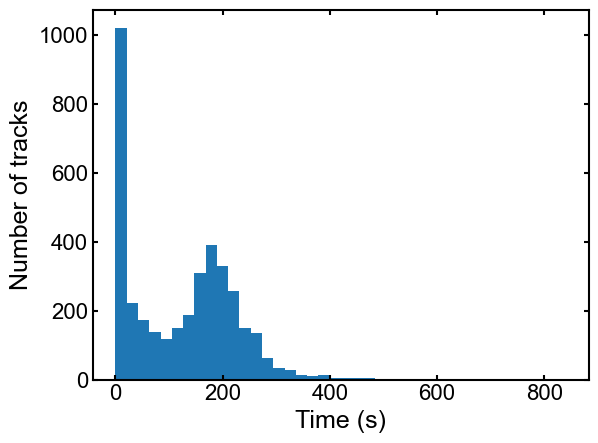

In [72]:
plt.hist(all_track_ts, bins = 40)
plt.xlabel('Time (s)')
plt.ylabel('Number of tracks')
plt.show()

This looks like it can be modeled by a mixture of an exponentially decaying component and a Gaussian. Let's fit to this functional form:

In [73]:
p_t_all, bins = np.histogram(all_track_ts, bins = 40, density = True)
t = (bins[1:] + bins[:-1])/2

In [74]:
def gaussian_envelope(x, mu, sigma, A):
    return A*np.exp((-(x-mu)**2)/(2*sigma**2))

def exponential_decay(x, b, A):
    return A*np.exp(-b*x)

In [75]:
def all_tracks_mixture_model(x,b1,A1,mu2,sigma2,A2, x_left = 0, x_right = 600):
    e1 = exponential_decay(x, b1, A1)
    g2 = gaussian_envelope(x, mu2, sigma2, A2)
    return np.logical_and(x < x_right, x > x_left) * (e1 + g2)

In [76]:
all_tracks_param_estimates= [0.1, 0.013, 180, 50, 0.005]

In [77]:
all_tracks_params, _ = curve_fit(f=all_tracks_mixture_model, xdata=t, ydata=p_t_all, p0=all_tracks_param_estimates)

In [78]:
print(all_tracks_params)

[6.39897168e-02 2.49447483e-02 1.80821306e+02 5.76216545e+01
 4.22121038e-03]


Looks like our parameter estimates were pretty close.

Let's make sure this is properly normalized:

In [79]:
t = np.arange(1e-5, 600, 0.01)
dt = t[1] - t[0]
p_t_all_cont = all_tracks_mixture_model(t, *all_tracks_params)
s_all_tracks = np.sum(p_t_all_cont*dt)
print("AUC = {}".format(np.round(s_all_tracks, 3)))

AUC = 0.999


So it isn't perfect, but it's pretty close.

Let's take the final step in turning this into a pdf:

In [80]:
def all_tracks_t_pdf(t):
    return all_tracks_mixture_model(t, *all_tracks_params)/s_all_tracks

Now let's overlay this pdf with the original histogram:

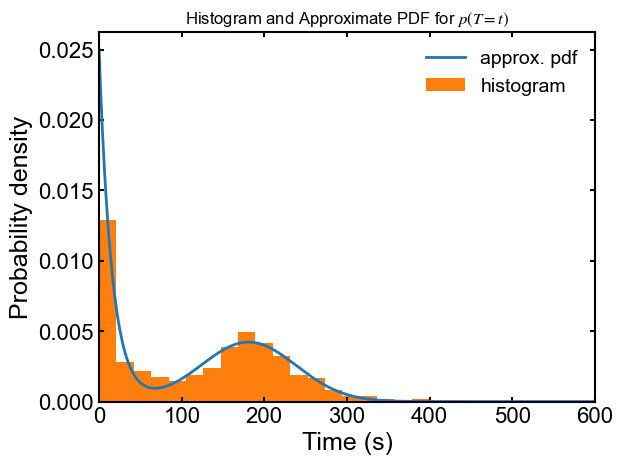

In [81]:
plt.title(r'Histogram and Approximate PDF for $p(T = t)$')
plt.plot(t, all_tracks_t_pdf(t), label = 'approx. pdf')
plt.hist(all_track_ts, bins = 40, density = True, label = 'histogram')
plt.xlim(0, 600)
plt.xlabel('Time (s)')
plt.ylabel('Probability density')
plt.legend(frameon = False, fontsize = 14)
plt.show()

#### $p(T = t | A)$

We can perform a similar sequence of operations for the tracks that I added to my library:

In [82]:
added_track_ts = list(new_tracks_df[new_tracks_df['addedQ']!= 'notAdded']['firstPlayDuration'])

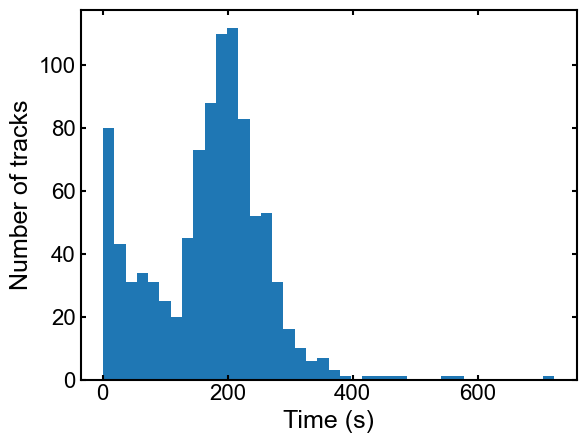

In [83]:
plt.hist(added_track_ts, bins = 40)
plt.xlabel('Time (s)')
plt.ylabel('Number of tracks')
plt.show()

This looks like it can be modeled by a mixture as well. This time however, we'll use a mixture of two Gaussians:

In [84]:
def added_tracks_mixture_model(x,mu1,sigma1,A1,mu2,sigma2,A2, x_left = 0, x_right = 600):
    g1 = gaussian_envelope(x, mu1, sigma1, A1)
    g2 = gaussian_envelope(x, mu2, sigma2, A2)
    return np.logical_and(x < x_right, x > x_left) * (g1 + g2)

In [85]:
p_t_added, bins = np.histogram(added_track_ts, bins = 20, density = True)
t = (bins[1:] + bins[:-1])/2

We can feed in estimates for the mean, std, and amplitude of the Gaussian envelopes, in order to guide the fitting procedure

In [86]:
added_tracks_param_estimates = [0, 50, 0.004, 200, 50, 0.007]

In [87]:
added_tracks_params, _ = curve_fit(f=added_tracks_mixture_model, xdata=t, ydata=p_t_added, p0=added_tracks_param_estimates)

In [88]:
print(added_tracks_params)

[-4.26520372e+01  6.84594316e+01  5.25300813e-03  1.98953747e+02
  4.90111302e+01  5.96958958e-03]


Now let's normalize:

In [89]:
t = np.arange(0.001, 600, 0.1)
dt = t[1] - t[0]
p_t_added_cont = added_tracks_mixture_model(t, *added_tracks_params)
s_added_tracks = np.sum(p_t_added_cont*dt)
print("AUC = {}".format(np.round(s_added_tracks, 3)))

AUC = 0.974


In [90]:
def added_tracks_t_pdf(t):
    return added_tracks_mixture_model(t, *added_tracks_params)/s_added_tracks

Now we can overlay this continuous approximation with the (normalized) histogram:

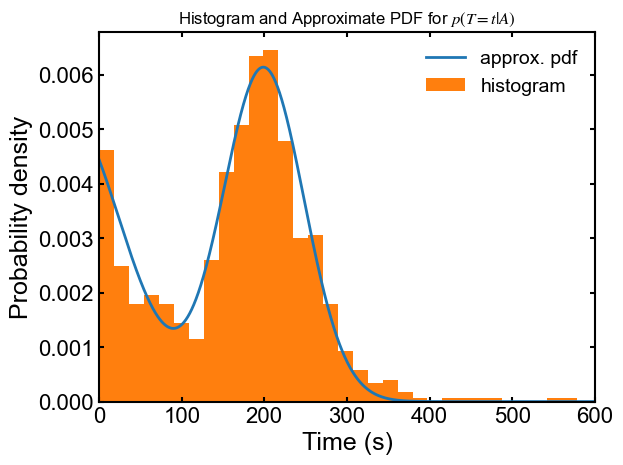

In [91]:
plt.title(r'Histogram and Approximate PDF for $p(T = t|A)$')
plt.plot(t, added_tracks_t_pdf(t), label = 'approx. pdf')
plt.hist(added_track_ts, bins = 40, density = True, label = 'histogram')
plt.xlim(0, 600)
plt.xlabel('Time (s)')
plt.ylabel('Probability density')
plt.legend(frameon = False, fontsize = 14)
plt.show()

#### $p(A|T = t)$

In [92]:
def p_added_t(t):
    return p_added * added_tracks_t_pdf(t)/all_tracks_t_pdf(t)

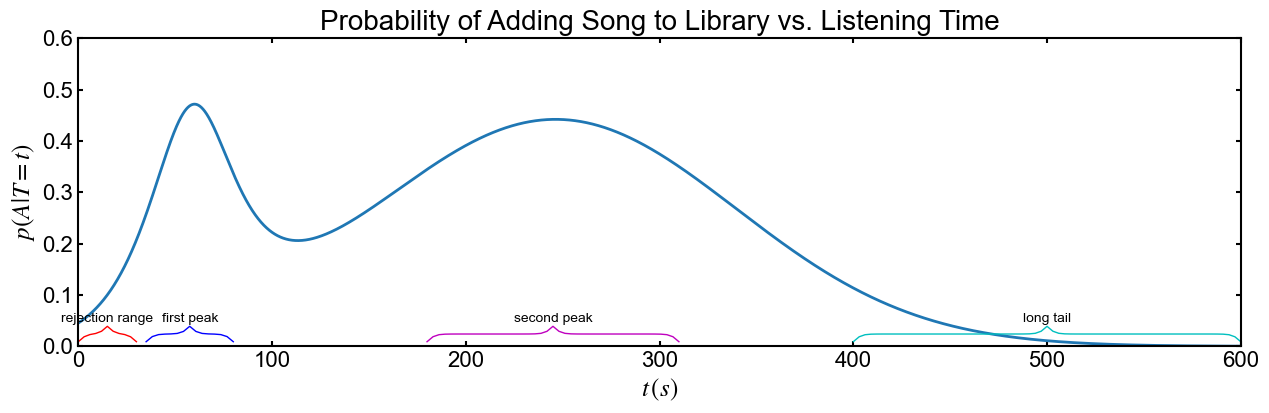

In [93]:
def draw_brace(ax, xspan, text, c = 'black'):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin
    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:resolution//2+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = ymin + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color=c, lw=1)

    ax.text((xmax+xmin)/2., ymin+.07*yspan, text, ha='center', va='bottom')


fig, ax = plt.subplots(figsize = (15, 4))
ax.set_xlabel(r'$t \,(s)$')
ax.set_ylabel(r'$p(A|T = t)$')

ax.plot(t, p_added_t(t))
ax.set_xlim(0, 600)
ax.set_ylim(0, 0.6)
draw_brace(ax, (0, 30), 'rejection range', c = 'r')
draw_brace(ax, (35, 80), 'first peak', c = 'b')
draw_brace(ax, (180, 310), 'second peak', c = 'm')
draw_brace(ax, (400, 600), 'long tail', c = 'c')


plt.title('Probability of Adding Song to Library vs. Listening Time', fontsize = 20) 
plt.show()

#### Interpretation

*Caveats*

First and foremost, I want to caution that these results should be taken with a massive grain of salt. There are many assumptions that went into generating this plot, and the data has been thoroughly massaged to arrive at this purported relationship. Generating continuous approximations to discrete distributions is in general a difficult problem, and the Bayesian inference performed only tells one side of the story. If I had access to the data, I would have studied the percent of the song's length I listened to, instead of the raw listening time. We'll do what we can with the limited data at our disposal...

**Rejection range**

If I listen to a song for less than thirty seconds before moving on, I'm almost certainly not adding it to my library. In this range, the quicker I move on, the less likely I am to add it to my library. In other words, there are a lot of songs that I can tell pretty quickly I don't like.

In [94]:
new_tracks_df['dayOfWeek'] = new_tracks_df.apply(lambda x: x['firstPlayTime'].strftime('%A'), axis = 1)
new_tracks_skipped_df = new_tracks_df[new_tracks_df['firstPlayDuration'] < 30]
print(new_tracks_skipped_df['dayOfWeek'].value_counts())

Thursday     324
Friday       306
Saturday     135
Monday       109
Sunday        93
Wednesday     82
Tuesday       80
Name: dayOfWeek, dtype: int64


As we can see, the vast majority of these short listens occur on Thursday and Friday. I'm likely going through the New Music Friday list and quickly skipping songs that are not my cup of tea.

**First peak**

The first peak (around one minute) likely corresponds, in part, to songs that I encountered during New Music Friday, listened to long enough to decide to add, and then moved on:

In [95]:
added_tracks_df = new_tracks_df[new_tracks_df['addedQ']!= 'notAdded']

In [96]:
less_than_80_cond = added_tracks_df['firstPlayDuration'] < 80
gtr_than_35_cond = added_tracks_df['firstPlayDuration'] > 35
first_peak_tracks_df = added_tracks_df[less_than_80_cond & gtr_than_35_cond]

In [97]:
first_peak_tracks_df.value_counts('dayOfWeek')

dayOfWeek
Friday       23
Thursday     21
Saturday     13
Sunday       12
Wednesday     9
Monday        8
Tuesday       3
dtype: int64

The majority of these additions happen on Thursday, Friday, and Saturday.

**Second peak**

I would guess that the second peak (around $t = 245s$, or roughly four minutes) corresponds mostly to non-instrumental tracks that I listened to all the way through and then added to my library. There is probably a strong representation from Discover Weekly.

In [98]:
less_than_310_cond = added_tracks_df['firstPlayDuration'] < 310
gtr_than_180_cond = added_tracks_df['firstPlayDuration'] > 180
second_peak_tracks_df = added_tracks_df[gtr_than_180_cond & less_than_310_cond].copy()

In [99]:
second_peak_tracks_df.value_counts('dayOfWeek')

dayOfWeek
Monday       102
Saturday      76
Friday        75
Thursday      59
Wednesday     58
Sunday        57
Tuesday       35
dtype: int64

In [100]:
second_peak_tracks_df['duration_s'] = 0.
for i in range(len(second_peak_tracks_df)):
    row = second_peak_tracks_df.iloc[i]
    tN, aN = row['trackName'], row['artistName']
    track_cond = (tracks_df['trackName'] == tN)
    artist_cond = (tracks_df['artistName'] == aN)
    second_peak_tracks_df.at[i, 'duration_s'] = list(tracks_df[track_cond & artist_cond]['duration_s'])[0]
second_peak_tracks_df['firstPlayPercentage'] = second_peak_tracks_df.apply(lambda x: min(1., x['firstPlayDuration']/max(1., x['duration_s'])), axis = 1)

In [101]:
second_peak_tracks_df.value_counts('firstPlayPercentage')

firstPlayPercentage
1.000000    873
0.911583      1
0.972489      1
0.965472      1
0.959747      1
0.939906      1
0.932454      1
0.921265      1
0.651429      1
0.678515      1
0.877759      1
0.864099      1
0.817726      1
0.761975      1
0.747749      1
0.741737      1
0.906030      1
dtype: int64

In [102]:
num_completed = len(second_peak_tracks_df[second_peak_tracks_df.firstPlayPercentage == 1])
num_not_completed = len(second_peak_tracks_df[second_peak_tracks_df.firstPlayPercentage != 1])
num_songs = num_completed + num_not_completed
print("Of the {} songs I listened to between 180s and 310s, I listened to {} of them all the way through, or {}%.".format(num_songs, num_completed, np.round(100*num_completed/num_songs, 2)))

Of the 889 songs I listened to between 180s and 310s, I listened to 873 of them all the way through, or 98.2%.


**Long tail**

The majority of the tracks that I listen to for longer than, say, $400$ seconds are primarily instrumental, and I'm most likely listening to them in the background while doing other things like cooking, eating, writing, or coding. Because this listening happens in the background, one of these songs has to really catch my attention for me to stop what I'm doing and add it to my library!

Get artists where `firstPlayDuration` $> 400$:

In [103]:
new_tracks_gtr_400_df = new_tracks_df[new_tracks_df['firstPlayDuration'] > 400]
new_tracks_gtr_400_artists = list(new_tracks_gtr_400_df['artistName'].unique())
print('Artists of Tracks I Listened to for more than 400s')
print('-'*80)
print(new_tracks_gtr_400_artists)

Artists of Tracks I Listened to for more than 400s
--------------------------------------------------------------------------------
['Janelle Monáe', 'Robert Glasper', 'Kanye West', 'Robert Glasper Trio', 'Christian Scott aTunde Adjuah', 'Butcher Brown', 'Stro Elliot', 'David Hazeltine', 'Xavier Davis', 'George Cables', 'Bill Charlap', 'Justice Der', 'Cory Weeds', 'Rowena Fysx', 'Varnish La Piscine', 'Parcels', 'Duke Ellington', 'Miles Davis', 'Ella Fitzgerald', 'Jaco Pastorius', 'Myd']


As expected, these artists are primarily jazz/instrumental!

## Is the Next Song by the Same Artist? <a class="anchor" id="is-the-next-song-by-the-same-artist"></a>

In [104]:
artists = streaming_df['artistName']

In [105]:
num_streams = len(streaming_df)
same_artist_count = 0

for i in range(num_streams-1):
    if artists[i] == artists[i+1]:
        same_artist_count += 1

In [106]:
percent_same_artist = same_artist_count/(num_streams-1) * 100
print("{}% of the time the next track I listen to will be by the same artist".format(np.round(percent_same_artist, 2)))

26.11% of the time the next track I listen to will be by the same artist


I strongly suspect that there is more structure here: I think that I listen to large portions of an artist's anthology at once. To test this, let's see what the probabilities are that if the last $k$ songs I've listened to are by one artist, track number $(k+1)$ will be by the same artist.

In [107]:
counts = []

def update_counts(counts, tmp_count):
    n = len(counts)
    if tmp_count > n:
        ndiff = tmp_count - n
        counts = counts + [0]*ndiff
    for i in range(tmp_count):
        counts[i] += tmp_count -i
    return counts

## Initializations
last_artist = artists[0]
tmp_count = 0

for i in range(1, num_streams):
    curr_artist = artists[i]
    if curr_artist == last_artist:
        tmp_count += 1
    else:
        last_artist = curr_artist
        counts = update_counts(counts, tmp_count)
        tmp_count = 0

### Add corrections for 2fold and 3fold occurrences based on our procedure
counts[0] += 2
counts[1] += 1

In [108]:
def compute_relisten_probs(counts, num_streams):
    probs = []
    for i in range(len(counts)):
        if i == 0:
            probs += [counts[0]/(num_streams - 1)]
        else:
            probs += [counts[i]/(counts[i-1])]
    return probs

In [109]:
relisten_probs = compute_relisten_probs(counts, num_streams)

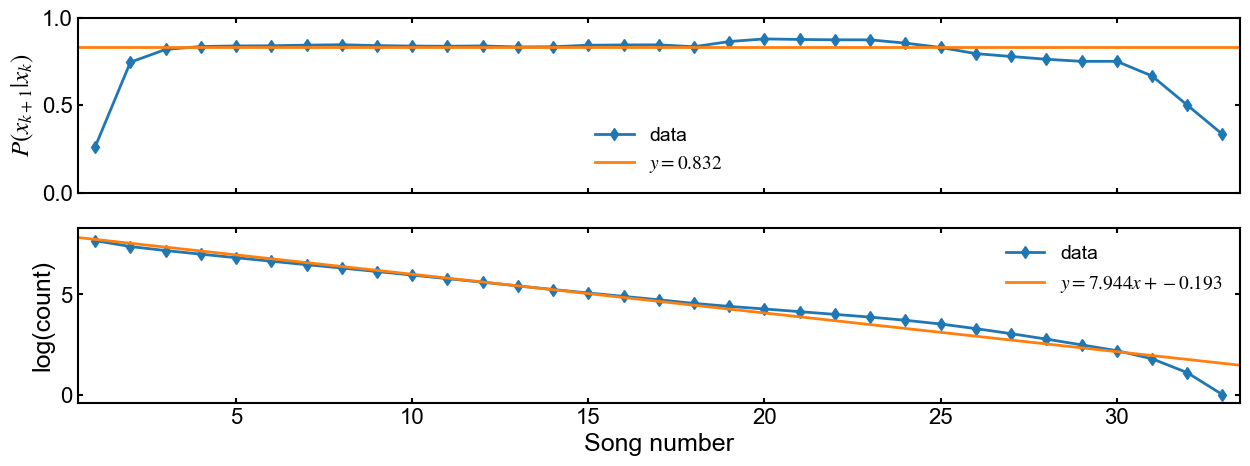

In [110]:
fig, ax = plt.subplots(2, 1, figsize = (15, 5), sharex = True)
x = np.arange(1, len(relisten_probs)+1)
xs = np.linspace(0, 40, 100)

ax[0].plot(x, relisten_probs, '-d', label = 'data')
popt_const, _ = curve_fit(const_func, x[3:-3], relisten_probs[3:-3])
ax[0].plot(xs, const_func(xs, *popt_const), label = r'$y = {}$'.format(np.round(popt_const[0], 3)))
ax[0].set_ylabel(r'$P(x_{k+1}|x_k)$')
ax[0].set_ylim(0, 1)
ax[0].legend(frameon = False, fontsize = 14)

ax[1].plot(x, np.log(counts), '-d', label = 'data')
popt_exp, _ = curve_fit(lin_func, x, np.log(counts))
ax[1].plot(xs, lin_func(xs, *popt_exp), label = r'$y = {}x + {}$'.format(*np.round(popt_exp, 3)))
ax[1].set_ylabel(r'log(count)')
ax[1].set_xlabel(r'Song number')
ax[1].legend(frameon = False, fontsize = 14)

plt.xlim(np.amin(x) - 0.5, np.amax(x) + 0.5)
plt.show()

Two things are clear from this plot:
1. After the second or third song from one artist, it is almost equally likely that I stop listening at any point - the probability of continuing to listen remains relatively constant as the number of songs increases. This can be seen by fitting this probability curve to a constant value, as shown in the yellow line in the upper axes.
2. The number of times I listen to $k$ songs by the same artist in a row falls off exponentially with $k$. Hence, the logarithm of the count is approximately linear in the song number.

In fact, the former implies the latter! We can see this behavior arise when we try modeling these statistics with a [geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution#Assumptions:_When_is_the_geometric_distribution_an_appropriate_model?). Let $p$ be the 'success' probability, or the probability that the next track I listen to is from a different artist than the last, and $q = 1 - p$ is the failure probability, wherein we continue to listen to the same artist. We assume for simplicity that each trial is independent, and that $p$ is constant, i.e. the same for all trials.

In this model, the probability that I listen to $k$ consecutive tracks by one artist before listening to a track by another artist is the probability of $k$ 'failures' before the first 'success'. This is:
$$ P(Y = k) = q^k p,$$
which of course decays linearly with $k$. 

It is worth noting that this model does not take into account the behavior at $k$ small or large. For $k = 1$, i.e. after I've listened to my first track by a given artist, the probability, $P(Y = 1) \approx 26\%$, which we calculated above, can be explained by the high frequencies at which I listen to playlists, including my own personal playlists, as well as Discover Weekly and New Music Friday. For large $k$, I suspect that the sample sizes are just too small to make for meaningful probabilities. For instance, only three times did I listen to $33$ songs in a row by a single artist, and only one of those times did I listen to $34$. Flipping one more of those to $34$ would increase the reported probability by $100\%$.

# Lyrics

In progress...

I've been playing around with LDA, BerTopic modeling, and some zero-shot/few-shot learning models, but have not yet hit on anything too cool. Will update this section when I do :)